# Enoncé: 
    
Nous allons implémenter une architecture auto encoder et découvrir ensemble l'un des cas d'applications. Nous allons à l'aide d'un autoencoder débruité des images.
L'objectif est d'entrainer un autoencoder à reproduire l'entrée qu'il a.
Comme nous diminuons l'information au centre de l'autoencoder, seul les informations les plus pertinentes sont conservées.
Celles-ci sont séléctionnées automatiquement par apprentissage. En effet, en essayant d'optimiser notre fonction de coût, l'autoencoder va, pour mimnimiser son erreur, conserver uniquement l'information qui a le plus d'impact sur la sortie.

Une fois que notre autoencoder est entraîné, on peut le réutiliser en lui donnant en entrée une image bruitée. L'autoencoder va ainsi nous retourner une image sans bruit.

Pour ce tp nous utiliserons les images du challenge mnist 

Vous devrez remplacer les "?" par le code. Appuyez vous sur la documentation keras

# 1.Import

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
import keras

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
print(keras.__version__)

Using TensorFlow backend.


2.3.1


# 2. Load dataset

In [3]:
(x_train, _), (x_test, _) = mnist.load_data()

In [4]:
def print_images(dataset, is_reshape=False):
    for i in range (10):
        item = random.randrange(0, dataset.shape[0], dataset.shape[0]/10)
        if is_reshape:
            img = dataset[item].reshape(28,28)
        else:
            img = dataset[item]
        plt.imshow(img, interpolation='nearest')
        plt.show()

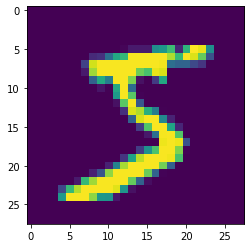

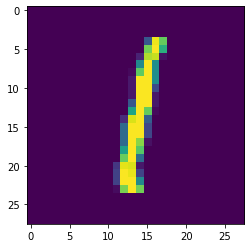

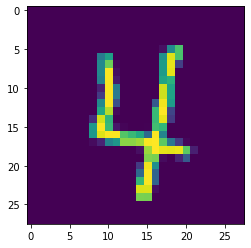

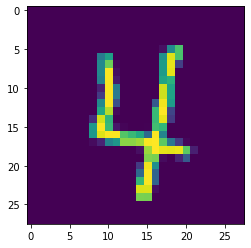

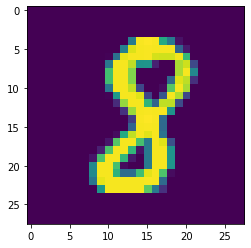

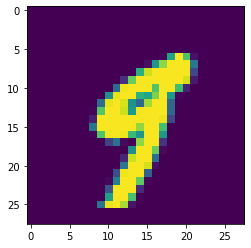

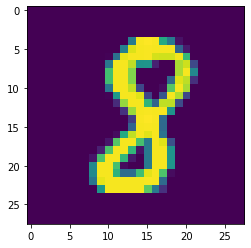

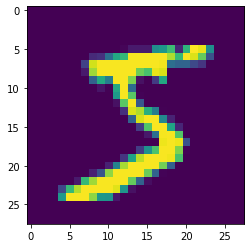

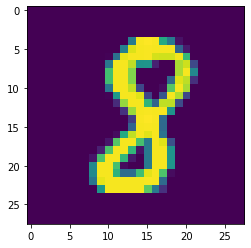

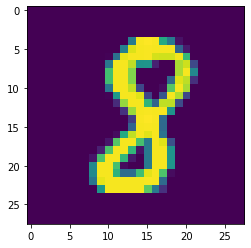

In [5]:
print_images(x_train)

## 2.1 Normalise data

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
# normalize train data
x_train = x_train.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
print(x_train.shape)

(60000, 28, 28, 1)


In [8]:
# normalize test data (which serves as our labels)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_test.shape)

(10000, 28, 28, 1)


## 2.2 Add noise

In [10]:
np.random.normal(loc=0.0, scale=1.0, size=x_train.shape).shape

(60000, 28, 28, 1)

In [11]:
np.random.normal(loc=0.0, scale=1.0, size=1)

array([1.27837446])

In [14]:
# create noisy data for train and test
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# renormalize through clipping
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [15]:
x_train_noisy.shape

(60000, 28, 28, 1)

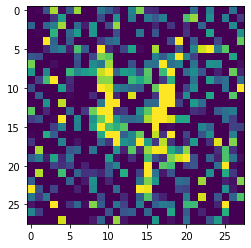

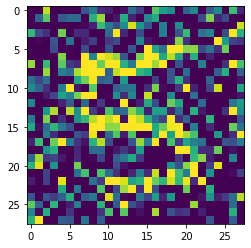

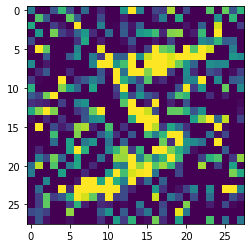

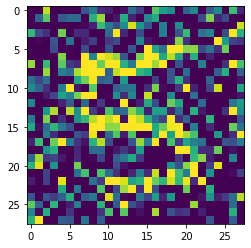

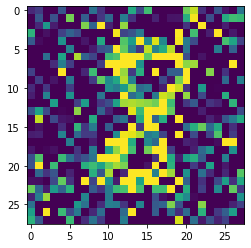

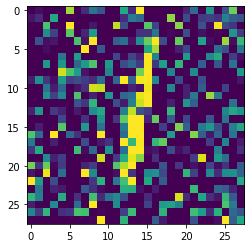

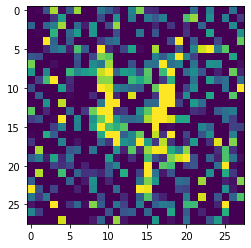

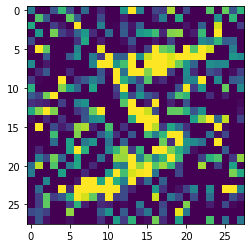

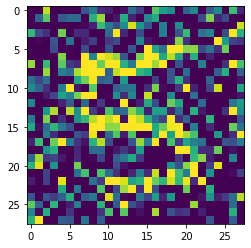

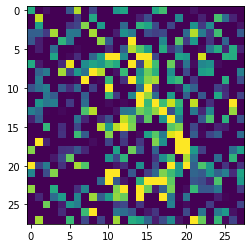

In [20]:
print_images(x_train_noisy, is_reshape=True)

# 3. Modeling

Pour modéliser plus facilement notre architecture nous allons nous baser sur utiliser Keras. Vous devrez modéliser un encoder et un decoder. Vous pouvez mettre autant de couches que vous le souhaitez, les principes d'architectures à respecter sont les suivants :
- L'encodeur doit compresser l'infomration au fur à mesure que l'on empile les couches
- Le décodeur doit agrandir l'information au fur à mesure que l'on empile les couches
- A la fin du décodeur l'infomration doit être de la même shape que la shape des images passées en entrée.

## 3.1 Encoder

L'encoder se compose de couches de [Convolution2D, MaxPooling2D]

In [ ]:
60000, 28, 28, Canaux

In [26]:
input = layers.Input(shape=(28, 28, 1))

In [27]:
#Construisez l'encoder en "stackant" des couches décrites ci dessus
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

## 3.2 Decoder

De la même manière que pour l'encoder, construisez le décodeur en impilant des couches. Ces couches se composent des deux éléments suivants : [Conv2DTranspose , Conv2D]
Utiliser une couche de Conv2DTranspose revient à enchaîner une couche d'UpSampling2D puis de Conv2D.


In [ ]:

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
#back to 28,28,1

## 3.3 Merge 
On combine alors l'encoder et le decoder, puis on définit une loss. Pour combiner le modèle basez vous sur Model()

In [29]:
# create the autoencoder by merging the encode and decode networks together
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 32)        9248  

# 4.0 Train

On entraîne le modèle.

In [30]:
# train
autoencoder.fit(x_train_noisy, x_train,
  nb_epoch=2,
  batch_size=256,
  shuffle=True,
  validation_data=(x_test_noisy, x_test))

W0104 10:13:52.412146 20920 training.py:701] The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 70s 1ms/sample - loss: 0.2559 - val_loss: 0.1320
Epoch 2/2
60000/60000 [==============================] - 76s 1ms/sample - loss: 0.1231 - val_loss: 0.1168


# 5.0 Use the model for denoying

In [31]:
decoded_imgs = autoencoder.predict(x_test_noisy)

# 6.0 Print the results

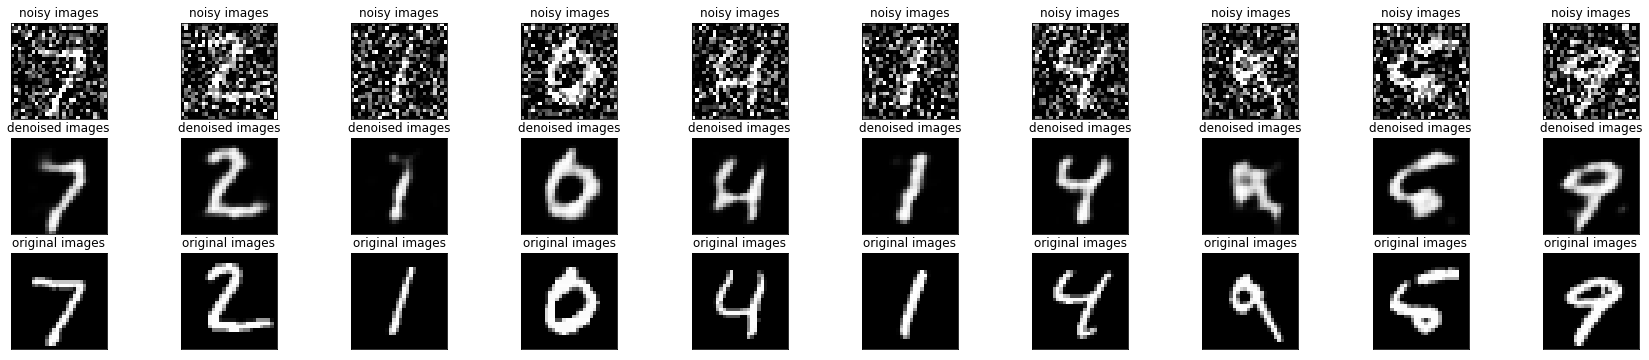

In [32]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_noisy[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)    
  ax.set_title('noisy images')

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('denoised images')

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax.set_title('original images')

plt.show()

# 7.0
Réalisez le même exercice sur fashion MNist et essayez plusieurs architectures d'autoencoders.